In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano
import theano.tensor as T

# Matrix Multiplication

In [8]:
c = T.scalar('c')
v = T.vector('v')
A = T.matrix('A')

In [11]:
w = A.dot(v)

matrix_times_vector = theano.function(inputs=[A, v], outputs=w)

In [12]:
A_val = np.array([[1, 2], [3, 4]])
v_val = ([5, 6])

w_val = matrix_times_vector(A_val, v_val)
print(w_val)

[ 17.  39.]


# Gradient Descent

In [13]:
x = theano.shared(20.0, 'x')

cost = x*x + x + 1

x_update = x - 0.3 * T.grad(cost, x)

`x` is not an "input", it's a thing you update.
In later examples, data and labels would go into the inputs and model params would go in the updates.

`Updates` takes in a list of tuples, each tuple has 2 things in it:
1. The shared variable to update 
2. the update expression

In [14]:
train = theano.function(inputs=[], outputs=cost, updates=[(x, x_update)])

for _ in range(30):
    cost_val = train()
    print(cost_val)
print(x.get_value())

421.0
67.99000000000001
11.508400000000005
2.471344000000001
1.0254150400000002
0.7940664064
0.7570506250239999
0.75112810000384
0.7501804960006143
0.7500288793600982
0.7500046206976159
0.7500007393116186
0.7500001182898588
0.7500000189263775
0.7500000030282203
0.7500000004845152
0.7500000000775225
0.7500000000124035
0.7500000000019845
0.7500000000003176
0.7500000000000508
0.7500000000000082
0.7500000000000013
0.7500000000000001
0.7500000000000001
0.75
0.75
0.7500000000000001
0.75
0.75
-0.4999999999763651


# 1 Hidden layer NN

In [20]:
def get_normalized_data():
    df = pd.read_csv('../datasets/mnist/train.csv')
    data = df.as_matrix().astype(np.float32)
    np.random.shuffle(data)
    X = data[:, 1:]
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    np.place(std, std == 0, 1)
    X = (X - mu) / std # normalize the data
    Y = data[:, 0]
    return X, Y

def y2indicator(y):
    N = len(y)
    y = y.astype(np.int32)
    ind = np.zeros((N, 10))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

def error_rate(p, t):
    return np.mean(p != t)

In [36]:
X, Y = get_normalized_data()
Xtrain = X[:-1000,]
Ytrain = Y[:-1000]
Xtest  = X[-1000:,]
Ytest  = Y[-1000:]
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

max_iter = 300
print_period = 10

lr = 0.00004
reg = 0.01

N, D = Xtrain.shape
batch_sz = 500
n_batches = N // batch_sz

M = 300
K = 10
W1_init = np.random.randn(D, M) / 28
b1_init = np.zeros(M)
W2_init = np.random.randn(M, K) / np.sqrt(M)
b2_init = np.zeros(K)

In [37]:
thX = T.matrix('X')
thT = T.matrix('T')

W1 = theano.shared(W1_init, 'W1')
b1 = theano.shared(b1_init, 'b1')
W2 = theano.shared(W2_init, 'W2')
b2 = theano.shared(b2_init, 'b2')

# Neural Net
thZ = T.nnet.relu( thX.dot(W1)+b1 ) 
thY = T.nnet.softmax( thZ.dot(W2)+b2 )

# Cost func
cost = -(thT * T.log(thY)).sum() + reg*((W1*W1).sum() + (b1*b1).sum() + (W2*W2).sum() + (b2*b2).sum())
prediction = T.argmax(thY, axis=1)

In [38]:
# update_W1 = W1 - lr*(T.grad(cost, W1) + reg*W1)
# update_b1 = b1 - lr*(T.grad(cost, b1) + reg*b1)
# update_W2 = W2 - lr*(T.grad(cost, W2) + reg*W2)
# update_b2 = b2 - lr*(T.grad(cost, b2) + reg*b2)
update_W1 = W1 - lr*T.grad(cost, W1)
update_b1 = b1 - lr*T.grad(cost, b1)
update_W2 = W2 - lr*T.grad(cost, W2)
update_b2 = b2 - lr*T.grad(cost, b2)

train = theano.function(
    inputs=[thX, thT],
    updates=[(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)],
)

get_prediction = theano.function(
    inputs=[thX, thT],
    outputs=[cost, prediction],
)

Cost / err at iteration i=0, j=0: 2343.117 / 0.867
Cost / err at iteration i=20, j=0: 269.581 / 0.075
Cost / err at iteration i=40, j=0: 222.720 / 0.058
Cost / err at iteration i=60, j=0: 202.017 / 0.049
Cost / err at iteration i=80, j=0: 189.713 / 0.047
Cost / err at iteration i=100, j=0: 181.416 / 0.043
Cost / err at iteration i=120, j=0: 175.604 / 0.043
Cost / err at iteration i=140, j=0: 171.327 / 0.042
Cost / err at iteration i=160, j=0: 168.185 / 0.043
Cost / err at iteration i=180, j=0: 165.861 / 0.043
Cost / err at iteration i=200, j=0: 164.057 / 0.043
Cost / err at iteration i=220, j=0: 162.545 / 0.043
Cost / err at iteration i=240, j=0: 161.318 / 0.041
Cost / err at iteration i=260, j=0: 160.285 / 0.041
Cost / err at iteration i=280, j=0: 159.372 / 0.041


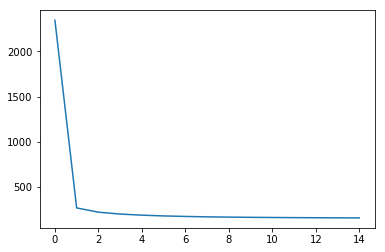

In [39]:
costs = []
for i in range(max_iter):
    for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

        train(Xbatch, Ybatch)
        if i%20==0 and j==0:
            cost_val, prediction_val = get_prediction(Xtest, Ytest_ind)
            err = error_rate(prediction_val, Ytest)
            print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, cost_val, err))
            costs.append(cost_val)

plt.plot(costs)
plt.show()